In [1]:
import os
import numpy as np
import torch
from data_loader import Amazon, Webcam, DSLR, classes

from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.utils as vutils

/home/gmvincen/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gmvincen/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
root = "/home/gmvincen/class_work/ece_792/Unsupervised-Domain-Adaptation/data"

In [3]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

# Load the datasets
amazon_dataset = Amazon(path=os.path.join(root, 'amazon'), transforms=transform)
webcam_dataset = Webcam(path=os.path.join(root, 'webcam'), transforms=transform)
dslr_dataset = DSLR(path=os.path.join(root, 'dslr'), transforms=transform)

In [4]:
# Calculate class distribution
amazon_class_counts = {}
for i, batch in enumerate(amazon_dataset):
    image, label = batch
    if label in amazon_class_counts:
        amazon_class_counts[label] += 1
    else:
        amazon_class_counts[label] = 1
        
# Calculate class distribution
dslr_class_counts = {}
for i, batch in enumerate(dslr_dataset):
    image, label = batch
    if label in dslr_class_counts:
        dslr_class_counts[label] += 1
    else:
        dslr_class_counts[label] = 1
        
# Calculate class distribution
webcam_class_counts = {}
for i, batch in enumerate(webcam_dataset):
    image, label = batch
    if label in webcam_class_counts:
        webcam_class_counts[label] += 1
    else:
        webcam_class_counts[label] = 1

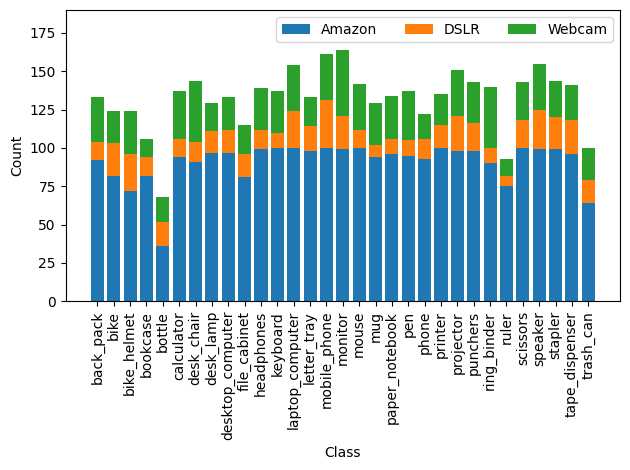

In [5]:
amazon = list(amazon_class_counts.values())
dslr = list(dslr_class_counts.values())
webcam = list(webcam_class_counts.values())

fig, ax = plt.subplots()
amazon_bars = ax.bar(amazon_class_counts.keys(), amazon, label='Amazon')
dslr_bars = ax.bar(dslr_class_counts.keys(), dslr, bottom = amazon, label='DSLR')
webcam_bars = ax.bar(webcam_class_counts.keys(), webcam, bottom=[sum(x) for x in zip(amazon, dslr)], label='Webcam')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticks(ticks=[i for i in range(0, len(classes))], labels=classes, rotation=90)
#ax.set_xticklabels(classes)
ax.legend(ncol=3)
ax.set_ylim(0, 190)
fig.tight_layout()
plt.savefig("figs/data_distribution.png", dpi=600, bbox_inches="tight")
plt.show()

In [6]:
amazon_dataset[0][1], webcam_dataset[0][1], dslr_dataset[0][1]

(25, 25, 25)

In [7]:
amazon_dataset[140][1], webcam_dataset[30][1], dslr_dataset[15][1]

(10, 10, 10)

In [8]:
amazon_dataset[900][1], webcam_dataset[275][1], dslr_dataset[150][1]

(11, 11, 11)

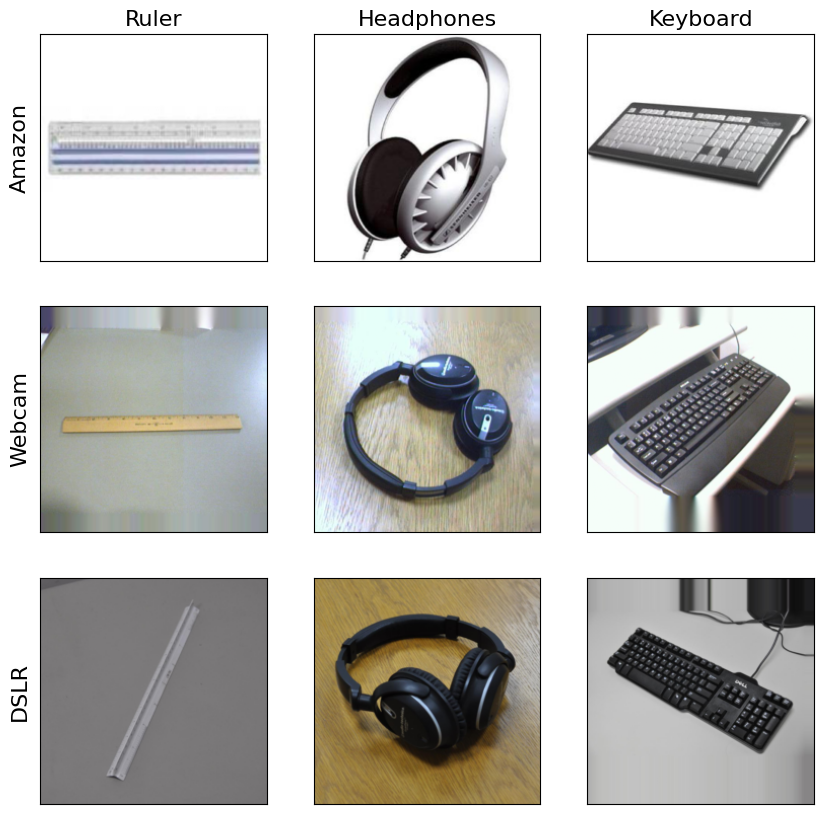

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

axs[0,0].set_title('Ruler', fontsize=16)
axs[0, 0].imshow(amazon_dataset[25][0].permute(1, 2, 0).numpy())
axs[1, 0].imshow(webcam_dataset[1][0].permute(1, 2, 0).numpy())
axs[2, 0].imshow(dslr_dataset[3][0].permute(1, 2, 0).numpy())

axs[0,0].set_xticks([])
axs[1,0].set_xticks([])
axs[2,0].set_xticks([])
axs[0,0].set_yticks([])
axs[1,0].set_yticks([])
axs[2,0].set_yticks([])

axs[0,0].set_ylabel('Amazon', fontsize=16)
axs[1,0].set_ylabel('Webcam', fontsize=16)
axs[2,0].set_ylabel('DSLR', fontsize=16)

axs[0,1].set_title('Headphones', fontsize=16)
axs[0, 1].imshow(amazon_dataset[140][0].permute(1, 2, 0).numpy())
axs[1, 1].imshow(webcam_dataset[30][0].permute(1, 2, 0).numpy())
axs[2, 1].imshow(dslr_dataset[15][0].permute(1, 2, 0).numpy())
axs[0,1].set_xticks([])
axs[1,1].set_xticks([])
axs[2,1].set_xticks([])
axs[0,1].set_yticks([])
axs[1,1].set_yticks([])
axs[2,1].set_yticks([])

axs[0,2].set_title('Keyboard', fontsize=16)
axs[0, 2].imshow(amazon_dataset[900][0].permute(1, 2, 0).numpy())
axs[1, 2].imshow(webcam_dataset[275][0].permute(1, 2, 0).numpy())
axs[2, 2].imshow(dslr_dataset[150][0].permute(1, 2, 0).numpy())
axs[0,2].set_xticks([])
axs[1,2].set_xticks([])
axs[2,2].set_xticks([])
axs[0,2].set_yticks([])
axs[1,2].set_yticks([])
axs[2,2].set_yticks([])

plt.savefig("figs/sample_imgs.png", dpi=600, bbox_inches="tight")
plt.show()

### Viewing the Random Gaussian Blurs

In [10]:
def add_perturbations(data):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=55, sigma=(0.1, 5.0)),
        ], p=0.75),
        transforms.ToTensor(),
    ])
    return transform(data)

def perturb_loader(loader):
    data, target = loader
    data_perturbed = torch.stack([add_perturbations(d) for d in data])
    return data_perturbed, target

In [11]:
web_dl = torch.utils.data.DataLoader(
    webcam_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=8,
    pin_memory=False,
)

In [12]:
batch = next(iter(web_dl))
perturbed_amazon, targets = perturb_loader(batch)

In [13]:
len(batch[0])

16

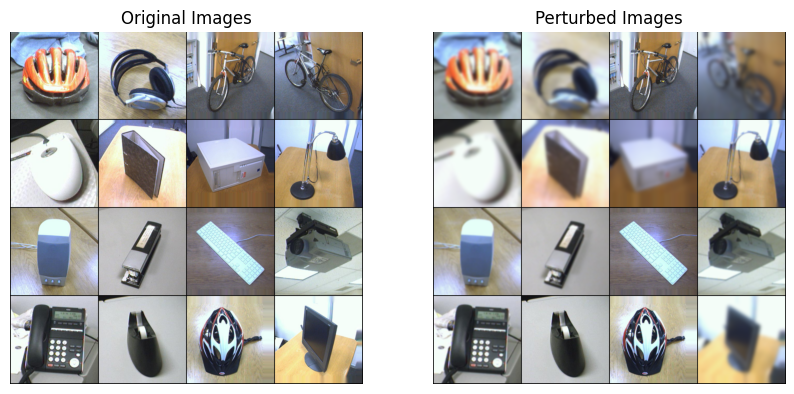

In [14]:
# plot the original images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Original Images")
axs[0].axis("off")
axs[0].imshow(vutils.make_grid(batch[0], nrow=4, padding=2, normalize=True).permute(1, 2, 0))

# plot the perturbed images
axs[1].set_title("Perturbed Images")
axs[1].axis("off")
axs[1].imshow(vutils.make_grid(perturbed_amazon, nrow=4, padding=2, normalize=True).permute(1, 2, 0))

plt.savefig("figs/perturbed_images.png", dpi=600, bbox_inches="tight")
plt.show()